In [1]:
import os
import numpy as np
import netCDF4 as nc4
import shutil
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [96]:
doanalysis = 1
paramfileroot='/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC/'

#where are we now?
read_params = 1

ensN=8
if ensN == 1:
    ens_directory='FATES_NOCOMP_FBG_PPE_LHC1'
    ncases=100
    ychoose =30
    pfileroot = paramfileroot+'nocomp_lhc_v1_'

if ensN == 2:
    ens_directory='FATES_NOCOMP_FBG_PPE_LHC2'
    ncases=99
    ychoose =20
    pfileroot = paramfileroot+'nocomp_lhc_v2_'
    
if ensN == 3:
    ens_directory='FATES_NOCOMP_FBG_PPE_LHC3_'
    ncases=49
    ychoose =10
    pfileroot = paramfileroot+'nocomp_lhc_v3_'

if ensN == 4:
    ens_directory='FATES_NOCOMP_FBG_PPE_LHC4_'
    ncases=49
    ychoose =30
    pfileroot = paramfileroot+'nocomp_lhc_v4_'


if ensN == 5:
    ens_directory = 'FATES_NOCOMP_FBG_PPE_LHC5_'
    ncases = 300
    ychoose = 30
    pfileroot = paramfileroot+'nocomp_lhc_v5_'
    read_model_output= 1
    read_params = 0 
    make_emulator = 1

if ensN == 6:
    ens_directory='FATES_NOCOMP_FBG_PPE_LHC6_'
    ncases=500
    ychoose =29
    pfileroot = paramfileroot+'nocomp_lhc_v6_'
    read_model_output=1
    
if ensN == 7:
    ncases=50
    ychoose =2
    read_model_output=1

if ensN == 8:
    ncases=500
    ychoose =29
    read_model_output=0


if ensN == 9:
    ncases=150
    ychoose =29
    read_model_output=1
    
ntest=75
ens_directory='FATES_NOCOMP_FBG_PPE_LHC'+str(ensN)+'_'
pfileroot = paramfileroot+'nocomp_lhc_v'+str(ensN)+'_'

ncls=5
pdatafile='../output_nocomp_ensemble_python/params_v'+str(ensN)+'.nc'
ldatafile='lai_output_'+str(ensN)+'.nc'
nppdatafile='npp_output_'+str(ensN)+'.nc'
varn='FATES_LAI'

figpath = ('figs_'+ens_directory+'/')
vs=range(1,ncases+1) 
figdir = 'figs_ensN_'+str(ensN)

fatesvar='FATES_LAI'
yl=6

USER='rfisher'

#path to scratch (or where the model is built.)
output_dir='/glade/derecho/scratch/'+USER+'/'

caseroot=ens_directory

sgpath='sgmap.nc'

print(ens_directory)

FATES_NOCOMP_FBG_PPE_LHC8_


In [4]:

conv = 3600*24*365
yr='.clm2.h0.'   


In [5]:
def make_directory(fileroot):   
    if(os.path.isdir(fileroot)):
        print('dir exists:'+fileroot)
    else:
        os.mkdir(fileroot)
        print('made: '+fileroot)

In [6]:
make_directory(figdir)

dir exists:figs_ensN_8


#### ANALYSIS: Choose variables to read in

In [7]:
vars=['FATES_GPP','FATES_NPP','FATES_LAI']
#,'QFLX_EVAP_TOT','FATES_GROWTH_RESP','FATES_LAI_CANOPY_SZ',
 #     'FATES_AREA_PLANTS','FATES_AREA_TREES','FATES_CANOPY_VEGC','FATES_USTORY_VEGC','FATES_TRIMMING','FATES_MAINT_RESP','FATES_LEAFMAINTAR','FATES_VEGC','FATES_VEGC_ABOVEGROUND','FATES_NPLANT_PF','FATES_TRIMMING','lat','lon','time']

 #### ANALYSIS: Make output figure directory

In [8]:
figpath = (os.getcwd() +'/'+ 'figs_'+ens_directory+'/')
make_directory(figpath)


dir exists:/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_FBG_PPE_LHC8_/


####  ANALYSIS: Make a single data structure for the ensemble

In [9]:
print(read_model_output)
if read_model_output==1:
    print(output_dir,ncases+1)
    caseroot=ens_directory
    vs=range(ncases)
    if doanalysis ==1:
        debug=0
        firstgo=1
        mins_ds=[]
        maxs_ds=[]
        count=1
        missing=range(0,ncases+1)
        missing=np.multiply(missing,0)
        for i in range(1,ncases+1):
            print(i)
            run=caseroot+str(i)
            if(ychoose<10):
                hstring='.clm2.h0.000'
            elif (ychoose<100):
                hstring='.clm2.h0.00'
            else:
                hstring='.clm2.h0.0' 
            #os.listdir(output_dir + '/archive')
            ahpath = output_dir + 'archive/' + run + '/lnd/hist/' 
            rhpath = output_dir + run + '/run/' 
            
            tfile = run+hstring+str(ychoose)+'-02-01-00000.nc'
            missing[i]=1
            #if(os.path.isdir(hpath)): ! #there is an archive
            if(os.path.isfile(rhpath+tfile)):  # this years is in the archive. 
                hpath = rhpath
                if debug == 1 :print('file in archive',rhpath)
                missing[i]=0
            else:
                if debug == 1 :print('file not in archive. try rundir')                
                hpath = ahpath       
                if(os.path.isdir(hpath)): 
                    #print('there is a rundir',hpath+tfile)                
                    if(os.path.isfile(hpath+tfile)):
                        if debug == 1 :print('file in  rundir')
                        missing[i]=0
                    else:
                        print('no file in rundir',hpath+tfile)
                else:
                    print('there is no  rundir',hpath+tfile)
                    
            if(missing[i]==0): # the year can be found. 
                rt=hpath+run+yr+str(ychoose)+'*'
                rt=hpath+tfile
                if(firstgo==1):
                    tmp = xr.open_mfdataset(rt, decode_times=False)  
                    allvars=list(xr.open_dataset(hpath+tfile, decode_times=False).variables)
                    dropvars=list(set(allvars) - set(vars)) 
                    firstgo=0
                #print('rt',rt)
                tmp=xr.open_mfdataset(rt, decode_times=False, drop_variables=dropvars)
            else:
                print('MISSING INPUT')
              
            if i==1:
                try: 
                    del dsc
                except:
                    print('no dsc')
                dsc = tmp           
            else:
                dsc=xr.concat([dsc,tmp],'ens')
    
    print('end')
else:
    print('not reading model output')

0
not reading model output


#### Read parameter files into a list. 

In [10]:

if(read_params==1):
    vsp=range(1,ncases+1) 
    print(pfileroot)
    paramsp=['not found'] * 100
    if doanalysis ==1:
        # loop round whole ensemble
        for i in vsp: 
            pfile1= xr.open_dataset(pfileroot+str(i)+'.nc')  
            if i==vsp[0]:
                try: 
                    del dsc_params
                except:
                    print('no dsc')
                all_param_data = pfile1                      
            else:
                all_param_data=xr.concat([all_param_data, pfile1], "ens")  
                 # Close the file
            pfile1.close()
else:
    all_param_data= xr.open_dataset(pdatafile) 
    


/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC/nocomp_lhc_v8_
no dsc


#### Write parameter output file

In [11]:

if(read_params==1):
    try:
        os.remove(pdatafile)
    except:
        print('no pfile')
        
    all_param_data.to_netcdf(pdatafile)  
    

#### Find modified parameters

In [12]:
directory_path = pfileroot
data1= xr.open_dataset(pfileroot+str(1)+'.nc') 
data2= xr.open_dataset(pfileroot+str(2)+'.nc') 
common_variables = set(data1.variables) & set(data2.variables)

# Iterate through the common variables and compare their values
parlist=[]
for var_name in common_variables:
    var_data1 = data1[var_name]
    var_data2 = data2[var_name]
    # Compare the values of the variables
    if not var_data1.equals(var_data2):
        parlist.append(var_name)

lhc_vars=parlist

if(ensN==8):
    lhc_vars=['fates_mort_hf_sm_threshold',
     'fates_phen_gddthresh_b', 'fates_mort_scalar_cstarvation', 
    'fates_grperc', 'fates_leaf_slamax', 'fates_phen_cold_size_threshold',
    'fates_phen_drought_threshold','fates_allom_d2ca_coefficient_min',
    'fates_rad_leaf_clumping_index',  'fates_leaf_slatop', 
    'fates_mort_scalar_coldstress','fates_allom_d2bl1',
    'fates_allom_d2ca_coefficient_max', 'fates_maintresp_leaf_vert_scaler_coeff2', 
    'fates_mort_scalar_hydrfailure', 'fates_mort_freezetol', 'fates_phen_mindayson',   
    'fates_leafn_vert_scaler_coeff2', 'fates_allom_fnrt_prof_b', 
    'fates_allom_d2bl2', 'fates_stoich_nitr', 'fates_maintresp_leaf_vert_scaler_coeff1', 'fates_phen_coldtemp',
    'fates_turnover_leaf', 'fates_recruit_seed_supplement', 'fates_q10_mr', 'fates_turnover_fnrt']
    parlist=lhc_vars
print(lhc_vars)
print(len(parlist))
print(len(lhc_vars))

['fates_mort_hf_sm_threshold', 'fates_phen_gddthresh_b', 'fates_mort_scalar_cstarvation', 'fates_grperc', 'fates_leaf_slamax', 'fates_phen_cold_size_threshold', 'fates_phen_drought_threshold', 'fates_allom_d2ca_coefficient_min', 'fates_rad_leaf_clumping_index', 'fates_leaf_slatop', 'fates_mort_scalar_coldstress', 'fates_allom_d2bl1', 'fates_allom_d2ca_coefficient_max', 'fates_maintresp_leaf_vert_scaler_coeff2', 'fates_mort_scalar_hydrfailure', 'fates_mort_freezetol', 'fates_phen_mindayson', 'fates_leafn_vert_scaler_coeff2', 'fates_allom_fnrt_prof_b', 'fates_allom_d2bl2', 'fates_stoich_nitr', 'fates_maintresp_leaf_vert_scaler_coeff1', 'fates_phen_coldtemp', 'fates_turnover_leaf', 'fates_recruit_seed_supplement', 'fates_q10_mr', 'fates_turnover_fnrt']
27
27


In [13]:
lhc_vars_title=np.copy(lhc_vars)
for i, var in enumerate(lhc_vars):
    original_string =var
    substring_to_remove = "fates_"
    lhc_vars_title[i] = var.replace(substring_to_remove, "")
    print(i,lhc_vars_title[i])  # Output: "HelloWorld!"

0 mort_hf_sm_threshold
1 phen_gddthresh_b
2 mort_scalar_cstarvation
3 grperc
4 leaf_slamax
5 phen_cold_size_threshold
6 phen_drought_threshold
7 allom_d2ca_coefficient_min
8 rad_leaf_clumping_index
9 leaf_slatop
10 mort_scalar_coldstress
11 allom_d2bl1
12 allom_d2ca_coefficient_max
13 maintresp_leaf_vert_scaler_coeff2
14 mort_scalar_hydrfailure
15 mort_freezetol
16 phen_mindayson
17 leafn_vert_scaler_coeff2
18 allom_fnrt_prof_b
19 allom_d2bl2
20 stoich_nitr
21 maintresp_leaf_vert_scaler_coeff1
22 phen_coldtemp
23 turnover_leaf
24 recruit_seed_supplement
25 q10_mr
26 turnover_fnrt


In [14]:
print(all_param_data.dims['ens'])
ensn=all_param_data.dims['ens']
x_array = np.zeros((ensn,len(parlist)))
plhc=all_param_data[parlist]
for i, var in enumerate(parlist):
    nd=all_param_data[var].ndim
    dnames=all_param_data[var].dims
    print(var)
    if(nd==1):
        param_mean=all_param_data[var] 
    elif nd==2:
        param_mean=all_param_data[var].mean('fates_pft')
    elif nd==3:
        param_mean=all_param_data[var].mean('fates_pft') 
        param_mean=param_mean.mean(dnames[1])
    x_array[:, i] = param_mean
    print(np.shape(x_array))
    print('i=',i,var,x_array[1:4,i])

500
fates_mort_hf_sm_threshold
(500, 27)
i= 0 fates_mort_hf_sm_threshold [2.4364e-06 2.3572e-06 1.0000e-05]
fates_phen_gddthresh_b
(500, 27)
i= 1 fates_phen_gddthresh_b [446.7276 659.054  994.1316]
fates_mort_scalar_cstarvation
(500, 27)
i= 2 fates_mort_scalar_cstarvation [0.676 0.896 4.339]
fates_grperc
(500, 27)
i= 3 fates_grperc [0.12292 0.09124 0.12256]
fates_leaf_slamax
(500, 27)
i= 4 fates_leaf_slamax [0.04539816 0.05637744 0.10586376]
fates_phen_cold_size_threshold
(500, 27)
i= 5 fates_phen_cold_size_threshold [61.6384 28.6714 19.8802]
fates_phen_drought_threshold
(500, 27)
i= 6 fates_phen_drought_threshold [-201353.12136 -149255.83092 -156016.548  ]
fates_allom_d2ca_coefficient_min
(500, 27)
i= 7 fates_allom_d2ca_coefficient_min [0.58713385 0.38407843 0.48114011]
fates_rad_leaf_clumping_index
(500, 27)
i= 8 fates_rad_leaf_clumping_index [0.7709 0.7688 0.8297]
fates_leaf_slatop
(500, 27)
i= 9 fates_leaf_slatop [0.02531867 0.02840587 0.02752187]
fates_mort_scalar_coldstress
(500,

#### write LAI output file

In [15]:
if(read_model_output==1):
    try:
        os.remove(ldatafile)
    except:
        print('no lfile')

In [16]:
if(read_model_output==1):
    nppmatrix=(dsc['FATES_NPP'].mean('time') )
    nppmatrix.to_netcdf(nppdatafile)

In [17]:
if(read_model_output==1):
    laimatrix=(dsc['FATES_LAI'].mean('time') )
    laimatrix.to_netcdf(ldatafile)  

In [18]:
l=xr.open_dataset(ldatafile)
print(l)

<xarray.Dataset>
Dimensions:    (ens: 500, gridcell: 400)
Dimensions without coordinates: ens, gridcell
Data variables:
    FATES_LAI  (ens, gridcell) float32 ...


In [19]:
n=xr.open_dataset(nppdatafile)
print(l)

<xarray.Dataset>
Dimensions:    (ens: 500, gridcell: 400)
Dimensions without coordinates: ens, gridcell
Data variables:
    FATES_LAI  (ens, gridcell) float32 ...


#### Read in Adrianna's ILAMB data file

In [20]:
import pandas as pd

ilamb_file='ILAMB_sparsegrid_data.csv'

ilamb_data = pd.read_csv(ilamb_file)
lat_lon_array = ilamb_data[['lat', 'lon']].values

lai_values = ilamb_data.loc[ilamb_data['variable'] == 'lai']
lai_values_modis = ilamb_data.loc[ilamb_data['model'] == 'MODIS']

lai_data_modis = lai_values_modis.loc[:, ['value', 'gridcell','lat','lon']]
lai_data_modis_sorted = lai_data_modis.sort_values(by='gridcell')
lai_data_modis_array = lai_data_modis_sorted.to_numpy()

lai_values_avhrr = ilamb_data.loc[ilamb_data['model'] == 'AVH15C1']
lai_data_avhrr = lai_values_avhrr.loc[:, ['value', 'gridcell','lat','lon']]
lai_values_avhrr = lai_values_avhrr.loc[:, ['value', 'gridcell','lat','lon']]

lai_data_avhrr = lai_values_avhrr.loc[:, ['value', 'gridcell','lat','lon']]
lai_data_avhrr_sorted = lai_data_avhrr.sort_values(by='gridcell')
lai_data_avhrr_array = lai_data_avhrr_sorted.to_numpy()




#### Plot out parameter space wrt MODIS LAI


In [21]:
plot_range=0
if(plot_range==1):    
    laiens=l.FATES_LAI
    laiens_s = np.swapaxes(laiens, 0, 1)
    #laiens_t = np.transpose(laiens)
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(27, 16))
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    
    for r in range(0,8):   
       # axes[r, 0].set_title(var,fontsize=20)   
        for e in range(len(laiens)):   
            axes[r-1].scatter(lai_data_modis_array[(r-1)*50:r*50,1],laiens_s[(r-1)*50:r*50,e],color='grey',s=8)
        axes[r-1].scatter(lai_data_modis_array[(r-1)*50:r*50,1], lai_data_avhrr_array[(r-1)*50:r*50,0],color='blue',s=100,marker='x')        
        axes[r-1].scatter(lai_data_modis_array[(r-1)*50:r*50,1], lai_data_modis_array[(r-1)*50:r*50,0],color='red',s=100,marker='x')        
        axes[r-1].set_ylabel('LAI', fontsize=18) 
        axes[r-1].set_ylim([0,6]) 
    axes[r-1].set_xlabel('Gridcell', fontsize=20) 
    plt.savefig(figpath+'/range_vs_data_'+fatesvar+'_y'+str(ychoose)+'Nens_'+str(ensN)+'.png',bbox_inches='tight')  
    plt.show()

#### Deal with any nans in the output

In [22]:

nan_indices = l.FATES_LAI.isnull().any(dim='ens')
# Use the where method to filter out NaN values along the 'time' dimension
filtered_data = l.FATES_LAI.where(~nan_indices, drop=True)
lnonan=filtered_data.fillna(999)


####  Map out parameter space

In [23]:
def map_param_space(g):
    rw=int(len(lhc_vars)/ncls)+1

    fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(27, 16))
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    fig.suptitle('Impacts of parameter variation on ' + fatesvar,y=0.93, fontsize=26)
    p=-1
    axcount=0
    timemean=dsc[fatesvar].mean('time')

    
    X=x_array
    yall=l.FATES_LAI[:,g]  
    yall=n.FATES_NPP[:,g]  
    yall=lnonan[:,g]
    yall=yall[0:len(x_array)]   
    
    print(yall.shape,np.shape(x_array))
    
    for i, var in enumerate(parlist):
        p=p+1
     #   print(p)
        row = axcount //ncls
        col = axcount % ncls        
        axcount=axcount+1    
        #print(np.shape(paramv), fates_output_data.shape)
        axes[row, col].set_title(var,fontsize=20)    
        diffplot=axes[row, col].scatter(x_array[:,i],yall)
        if(row>1):
            axes[row, col].set_yticklabels([], fontsize=18) 
        if(col>1):
            axes[row, col].set_yticklabels([], fontsize=18) 
        #axes[row, col].set_ylim([0,yl]) 
    while axcount < rw*ncls:
        row = axcount //ncls
        col = axcount %ncls
        axes[row, col].remove()
        axcount += 1
    
    plt.savefig(figpath+'x_vs_y'+fatesvar+'_y'+str(ychoose)+'_g'+str(g)+'.png',bbox_inches='tight')  
    plt.show()

#### Make different types of statistical model  

In [24]:
import statsmodels.api as sm
from scipy import stats

In [25]:
# Load a sample dataset (Boston housing dataset)
def random_forest(g,fgs,feat):
    yall=lnonan[:,g]
    yall=yall[0:len(x_array)]   
    X=x_array
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X,yall, test_size=0.2, random_state=42)
    
    # Create a random forest regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model to the training data
    rf_model.fit(X_train, y_train)
    rf_models.append(rf_model)

    # Make predictions on the testing data
    y_pred = rf_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)

    if(fgs==1 ):
       # map_param_space(g)
        fig = plt.figure()
        plt.scatter(y_pred,y_test,color='blue')
            #plt.scatter(tr_predictions,y)
    r_squared = stats.pearsonr(y_pred, y_test)[0] ** 2
    if(feat==1):
        feature_importances = rf_model.feature_importances_
    
    # Create a DataFrame to display the feature importances
        #feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        #feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
        feature_importances_df = pd.DataFrame({'Feature Importance': feature_importances})
        feature_importances_df['FeatureIndex'] = range(0, len(feature_importances_df) )

        feature_importances_df = feature_importances_df.sort_values(by='Feature Importance', ascending=False)
    
        # Display the dominant factors
        #print(feature_importances_df.FeatureIndex.iloc[1:4])
        featimp=feature_importances_df.FeatureIndex.iloc[0:4]
    return r_squared,featimp


In [26]:
def linear_regression(g,fgs):
    yall=lnonan[:,g].values
    yall=yall[0:len(x_array)]      
    X=x_array
    X_train, X_test, y_train, y_test = train_test_split(X,yall, test_size=0.2, random_state=42)
    
    model = sm.OLS(y_train, X_train).fit()  # Fit the multivariate linear regression model
   # print(model.summary())
    predictions = model.predict(X_test)
    tr_predictions = model.predict(X)
    if(fgs==1):
        #map_param_space(g)
        plt.scatter(predictions,y_test,color='green')
        #plt.scatter(tr_predictions,y)
    residuals = model.resid

# Calculate the standard deviation of predictions
  #  std_dev_predictions = residuals.std()
  #  rel_dev=np.divide(std_dev_predictions,np.mean(y))

    r_squared = stats.pearsonr(predictions, y_test)[0] ** 2
    return r_squared

In [27]:

def make_emulator_for_point(g,fgs):
    yall=lnonan[:,g]
    yall=yall[0:len(x_array)]      
    X=x_array
    X_train, X_test, y_train, y_test = train_test_split(X,yall, test_size=0.2, random_state=42)
    
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    y_pred =gp.fit(X_train, y_train)
    test_prediction, std_prediction = gp.predict(X_test, return_std=True)
    #r2 = r2_score(ytest, test_prediction) 
    
    if(np.max(test_prediction)==0):
        print('emulator fail')
    else:
        print(np.mean(test_prediction))
  
    if(fgs==1):
        #fig = plt.figure()
        #ax = fig.add_subplot()
        plt.scatter(test_prediction,y_test, color='red', marker='o')
        #ax.scatter(test_prediction,ytest)
        #ax.set_xlabel('LAI emulator')
        #ax.set_ylabel('LAI FATES')
        plt.savefig(figdir+'/emulator_xy_test_'+str(ensN)+'_'+fatesvar+'_g'+str(g)+'.png', bbox_inches='tight')
        plt.show()

    r_squared = stats.pearsonr(test_prediction, y_test)[0] ** 2
    return r_squared
    

#### Run emulators

In [31]:
from scipy import stats
nrep=6

In [32]:
rf_st=np.zeros(355)
lr_st=np.zeros(355)
gp_st=np.zeros(355)

In [33]:
rf_models = []
feat_importance = np.zeros([355,4], dtype=int)
for g in range(0,nrep):
    rf_st[g],feat_importance[g,:]=random_forest(g,0,1)
    lr_st[g]=linear_regression(g,0)
    gp_st[g]=make_emulator_for_point(g,0)
    print('g='+str(g),'rf:',rf_st[g],'lr:',lr_st[g],'gp:',gp_st[g])
    print(feat_importance[g,:],lhc_vars[feat_importance[g,0]],
         lhc_vars[feat_importance[g,1]],
         lhc_vars[feat_importance[g,2]])

emulator fail
g=0 rf: 0.35738852999369114 lr: 0.027489207364215923 gp: nan
[11 12 22 16] fates_allom_d2bl1 fates_allom_d2ca_coefficient_max fates_phen_coldtemp
emulator fail
g=1 rf: 0.5776387459057029 lr: 0.05321769009266518 gp: nan
[11 12 16  4] fates_allom_d2bl1 fates_allom_d2ca_coefficient_max fates_phen_mindayson
emulator fail
g=2 rf: 0.5835837855698388 lr: 0.021985594801010394 gp: nan
[11 12  4 16] fates_allom_d2bl1 fates_allom_d2ca_coefficient_max fates_leaf_slamax
emulator fail
g=3 rf: 0.598574326819115 lr: 0.05331067736916405 gp: nan
[11 12 22  4] fates_allom_d2bl1 fates_allom_d2ca_coefficient_max fates_phen_coldtemp
emulator fail
g=4 rf: 0.6705324422372304 lr: 0.07897898606259292 gp: nan
[11 12  4 22] fates_allom_d2bl1 fates_allom_d2ca_coefficient_max fates_leaf_slamax
emulator fail
g=5 rf: 0.7976298319965966 lr: 0.009961367611766598 gp: nan
[11 12  4 17] fates_allom_d2bl1 fates_allom_d2ca_coefficient_max fates_leaf_slamax


In [73]:
num_samples=20000
print(np.shape(lhc_vars),len(lhc_vars))
print(np.shape(x_array))
num_variables = len(lhc_vars)
hypercube = np.zeros((num_samples, num_variables))
print(np.shape(hypercube))
for i in range(num_variables):
    hypercube[:, i] = np.random.permutation(np.linspace(0, 1, num_samples))

hypercube = np.zeros((num_samples, num_variables))
for i in range(num_variables):
    hypercube[:, i] = np.random.permutation(np.linspace(0, 1, num_samples))

print(num_variables,np.shape(hypercube),num_samples,np.shape(x_array))

(27,) 27
(500, 27)
(20000, 27)
27 (20000, 27) 20000 (500, 27)


In [74]:
hypercube_scaled=np.zeros((num_samples, num_variables))
print(np.size(hypercube_scaled))
#for i  in range(5):
for i, var in enumerate(lhc_vars):
    mx=np.max(x_array[:,i])
    mn=np.min(x_array[:,i])
    for e in range(num_samples):
        hypercube_scaled[e,i]=(hypercube[e,i]*(mx-mn))+mn
    print(i,mn,mx)
Xdense=hypercube_scaled
for i, var in enumerate(lhc_vars):
    print('xd',i,var,np.min(Xdense[:,i]),np.max(Xdense[:,i]))

540000
0 1e-07 1e-05
1 319.0 1148.4
2 0.5 6.0
3 0.07000000000000002 0.12999999999999998
4 0.030600000000000006 0.11016000000000002
5 0.10000000000000002 100.0
6 -275323.31999999995 -76478.69999999998
7 0.2977352166666667 0.5954704333333334
8 0.5 0.85
9 0.02266666666666667 0.029466666666666665
10 0.5 6.0
11 0.012000000000000002 0.06000000000000002
12 0.2977352166666667 1.0718467800000002
13 0.486 2.43
14 0.5 6.0
15 -73.125 -20.3125
16 3888000000000000.0 1.39968e+16
17 1.215 4.374000000000001
18 0.8541666666666666 3.0750000000000006
19 1.0 2.0
20 0.011555835083333335 0.021460836583333337
21 0.004815 0.017333999999999995
22 3.75 13.5
23 0.9624999999999998 1.7875000000000003
24 0.0 5.0
25 1.0499999999999998 1.9500000000000002
26 0.5833333333333334 2.1
xd 0 fates_mort_hf_sm_threshold 1e-07 1e-05
xd 1 fates_phen_gddthresh_b 319.0 1148.4
xd 2 fates_mort_scalar_cstarvation 0.5 6.0
xd 3 fates_grperc 0.07000000000000002 0.12999999999999998
xd 4 fates_leaf_slamax 0.030600000000000006 0.1101600000

#### Make a prediction for bigger LHC

### Find simulations with acceptable LAI

In [75]:
y_pred_noise_arr = []
print(count_true)
for g in range(0,nrep):
    y_pred_noise_arr.append(rf_models[g].predict(Xdense))
    print('ypred',np.min(  y_pred_noise_arr[g]),np.max( y_pred_noise_arr[g]))

    

0
ypred 0.2368780831247568 3.162120561003685
ypred 0.24791179962456225 3.3158082377910616
ypred 0.3059098006412387 5.319716410636902
ypred 0.2246130158752203 3.6475389420986177
ypred 0.31514394134283064 2.472073185443878
ypred 0.3243282714486122 4.804644134044647


In [76]:
def find_acceptable_models(gt):
    y_pred_noise=y_pred_noise_arr[g]
    ld=lai_data_avhrr_array[gt][0]
    y_accept_lai=np.where(np.logical_and(y_pred_noise>=ld-0.1, y_pred_noise<=ld+0.1))   
    print(g,np.shape(y_accept_lai),ld,np.min(y_pred_noise),np.max(y_pred_noise))
    #if(np.size(y_accept_lai)>1):
       # print('range',ld,np.min(y_pred_noise[y_accept_lai]),np.max(y_pred_noise[y_accept_lai]))
    return y_accept_lai


In [77]:
accept_lai_g = []
for g in range(0,nrep):
    accept_lai_g.append(find_acceptable_models(g))

0 (1, 2155) 0.817071607718796 0.2368780831247568 3.162120561003685
1 (1, 1672) 0.938048459682307 0.24791179962456225 3.3158082377910616
2 (1, 0) nan 0.3059098006412387 5.319716410636902
3 (1, 1497) 0.42022903336008 0.2246130158752203 3.6475389420986177
4 (1, 0) 0.188871069946812 0.31514394134283064 2.472073185443878
5 (1, 445) 2.58282044071836 0.3243282714486122 4.804644134044647


#### Draw selected parameter space

In [78]:
print(np.max(   l.FATES_LAI[:,0]).values,np.max(   l.FATES_LAI[:,2]).values)

4.296432971954346 7.067158222198486


In [97]:
def draw_selected_param_space(g):
    ncls=5
    fig = plt.figure()
    rw=int(len(lhc_vars)/ncls)+1
    fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(16, 16))
    fig.suptitle('Emulated impact of parameter range on mean annual ' + varn,y=0.93)
    plt.subplots_adjust(wspace=0.1, hspace=0.35)  
    axcount=0
    y_accept_lai=accept_lai_g[g]
    y_pred_noise  = y_pred_noise_arr[g]
    Xsh=Xdense.shape

    #print('limxmn',np.min(l.FATES_LAI[:,g]).values,np.max(l.FATES_LAI[:,g]).values)
    #print('ypred',np.min(y_pred_noise),np.max( y_pred_noise))

    for i, var in enumerate(lhc_vars):  
        row = axcount // ncls
        col = axcount % ncls 
        axcount=axcount+1
        # emulated hypercube
        #print('xarr',g,i,np.min(Xdense[:,i]),np.max(Xdense[:,i]))
        #print('xden',g,i,np.min(x_array[:,i]),np.max(x_array[:,i]))       
        #print(np.shape(y_pred_noise),np.shape(y_pred_noise[y_accept_lai]))
        axes[row, col].scatter(Xdense[:,i], y_pred_noise, color='grey',s=2)    
        # FATES runs
        axes[row, col].scatter(x_array[:,i],   l.FATES_LAI[:,g], s=14, edgecolor='black',color='red')
        axes[row, col].scatter(Xdense[y_accept_lai,i], y_pred_noise[y_accept_lai], color='y',s=4) 
        
        axes[row, col].set_xlabel(lhc_vars_title[i], fontsize=11)   
        if(col==0):
            axes[row, col].set_ylabel(varn, fontsize=14)   
    while axcount < rw*ncls:
        row = axcount //ncls
        col = axcount %ncls
        axes[row, col].remove()
        axcount += 1
    plt.savefig(figdir+'/emulator_and_ensemble_'+str(ensN)+'_'+varn+'_g'+str(g)+'.png', bbox_inches='tight')
    plt.show()

<Figure size 640x480 with 0 Axes>

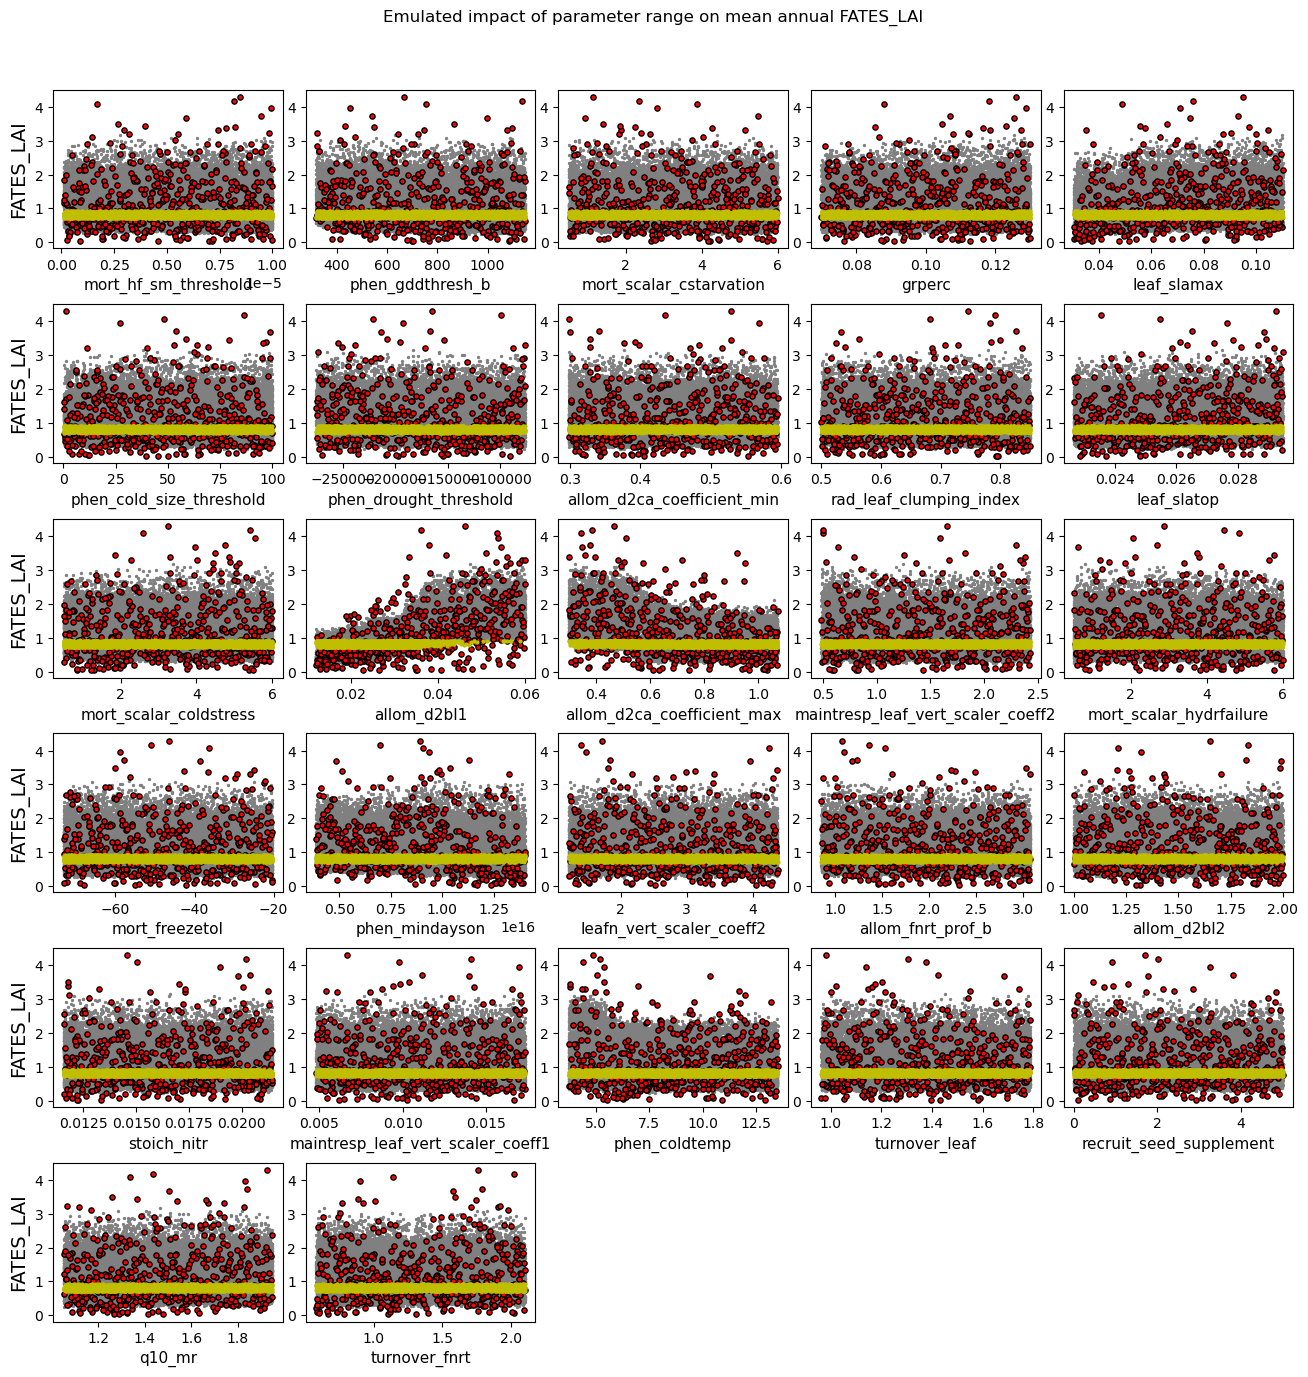

<Figure size 640x480 with 0 Axes>

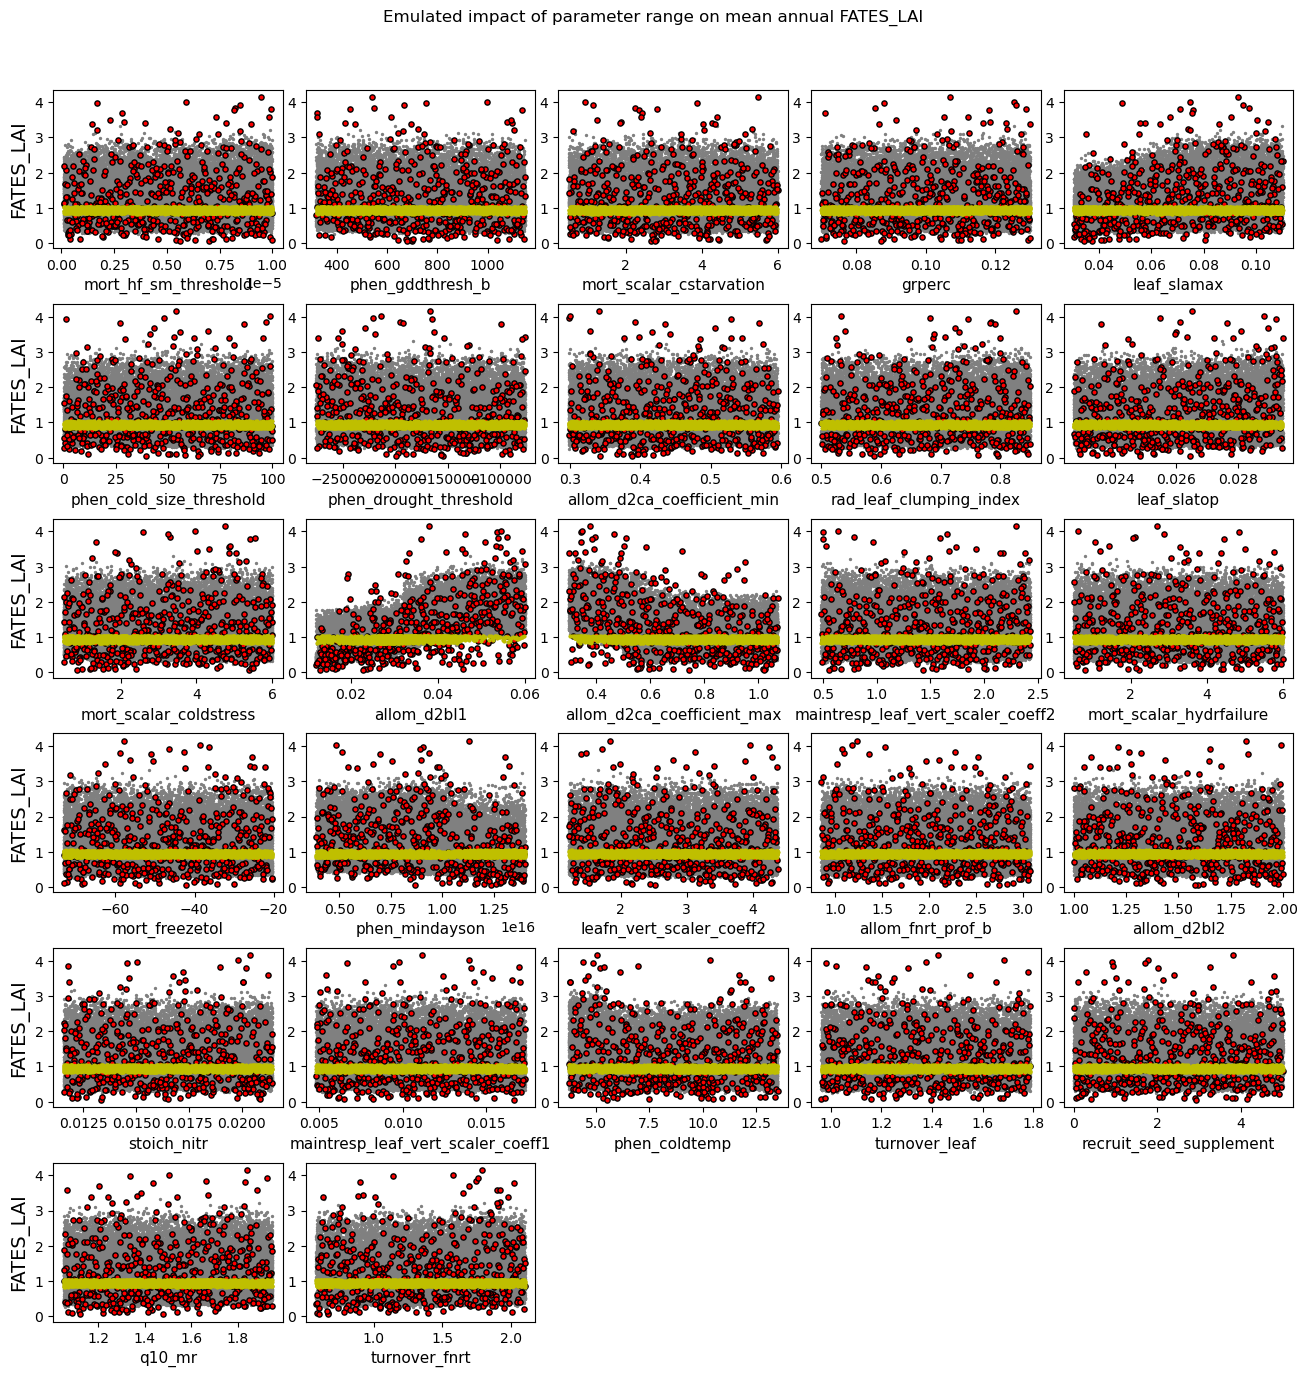

<Figure size 640x480 with 0 Axes>

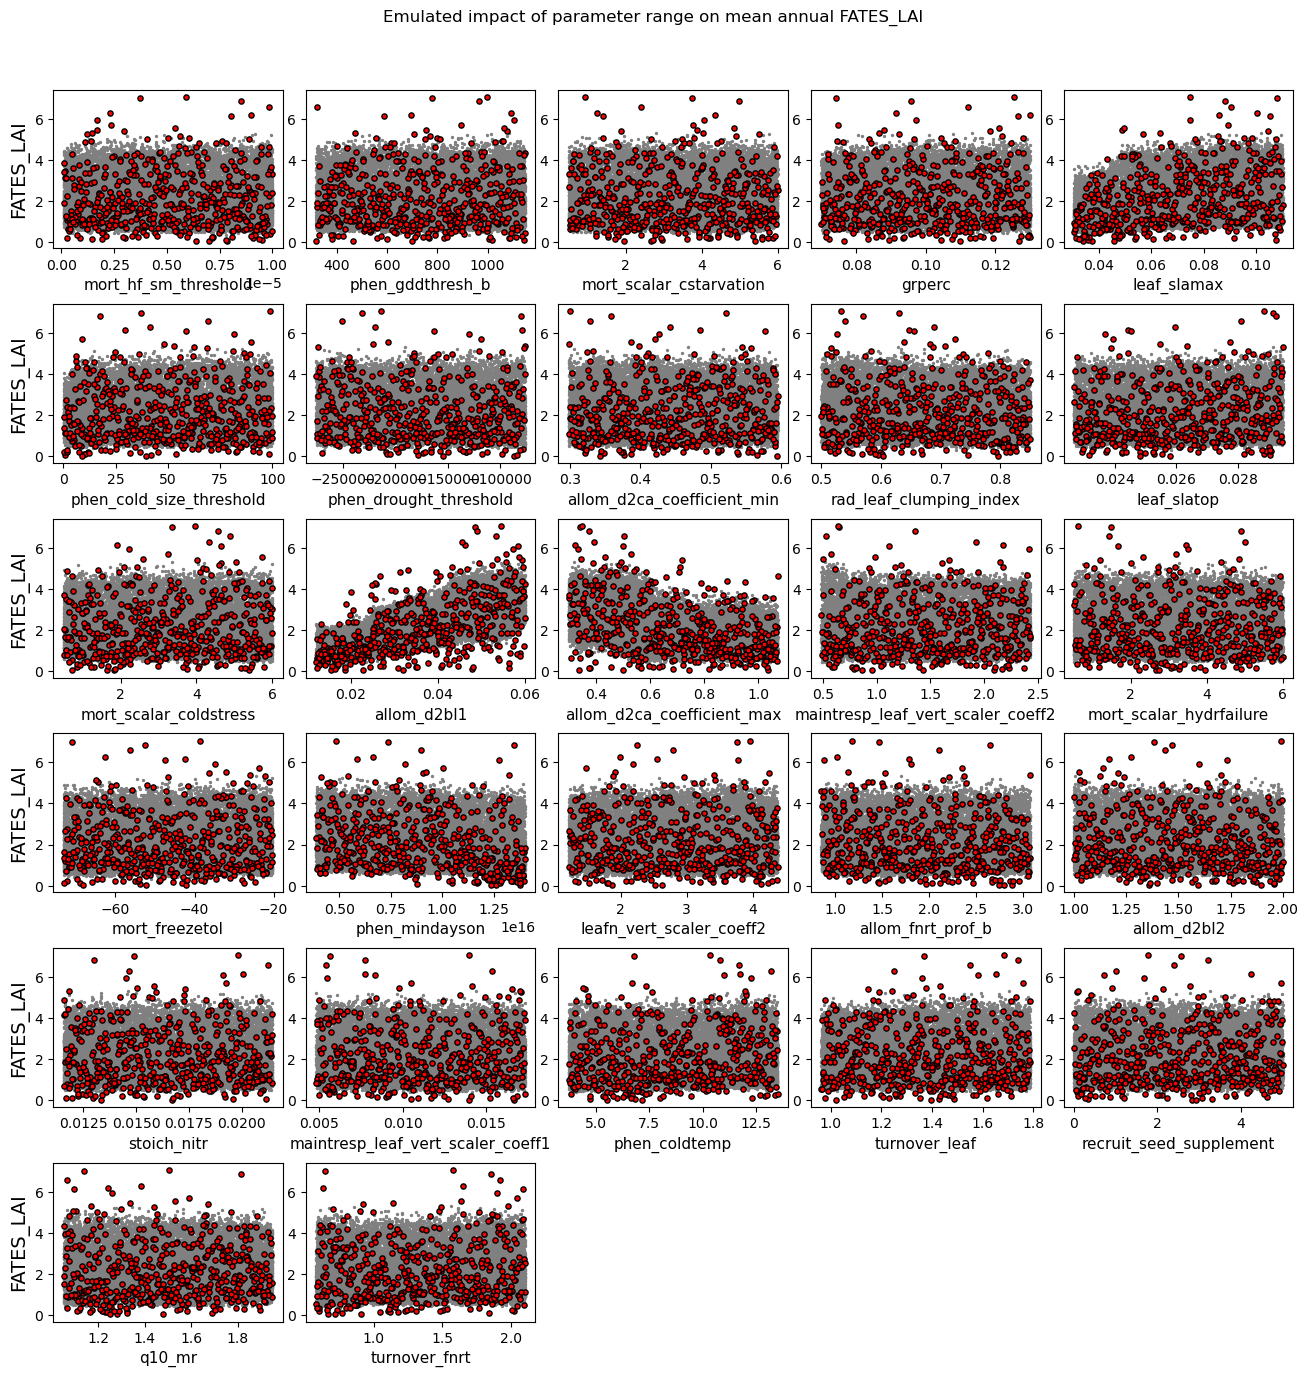

<Figure size 640x480 with 0 Axes>

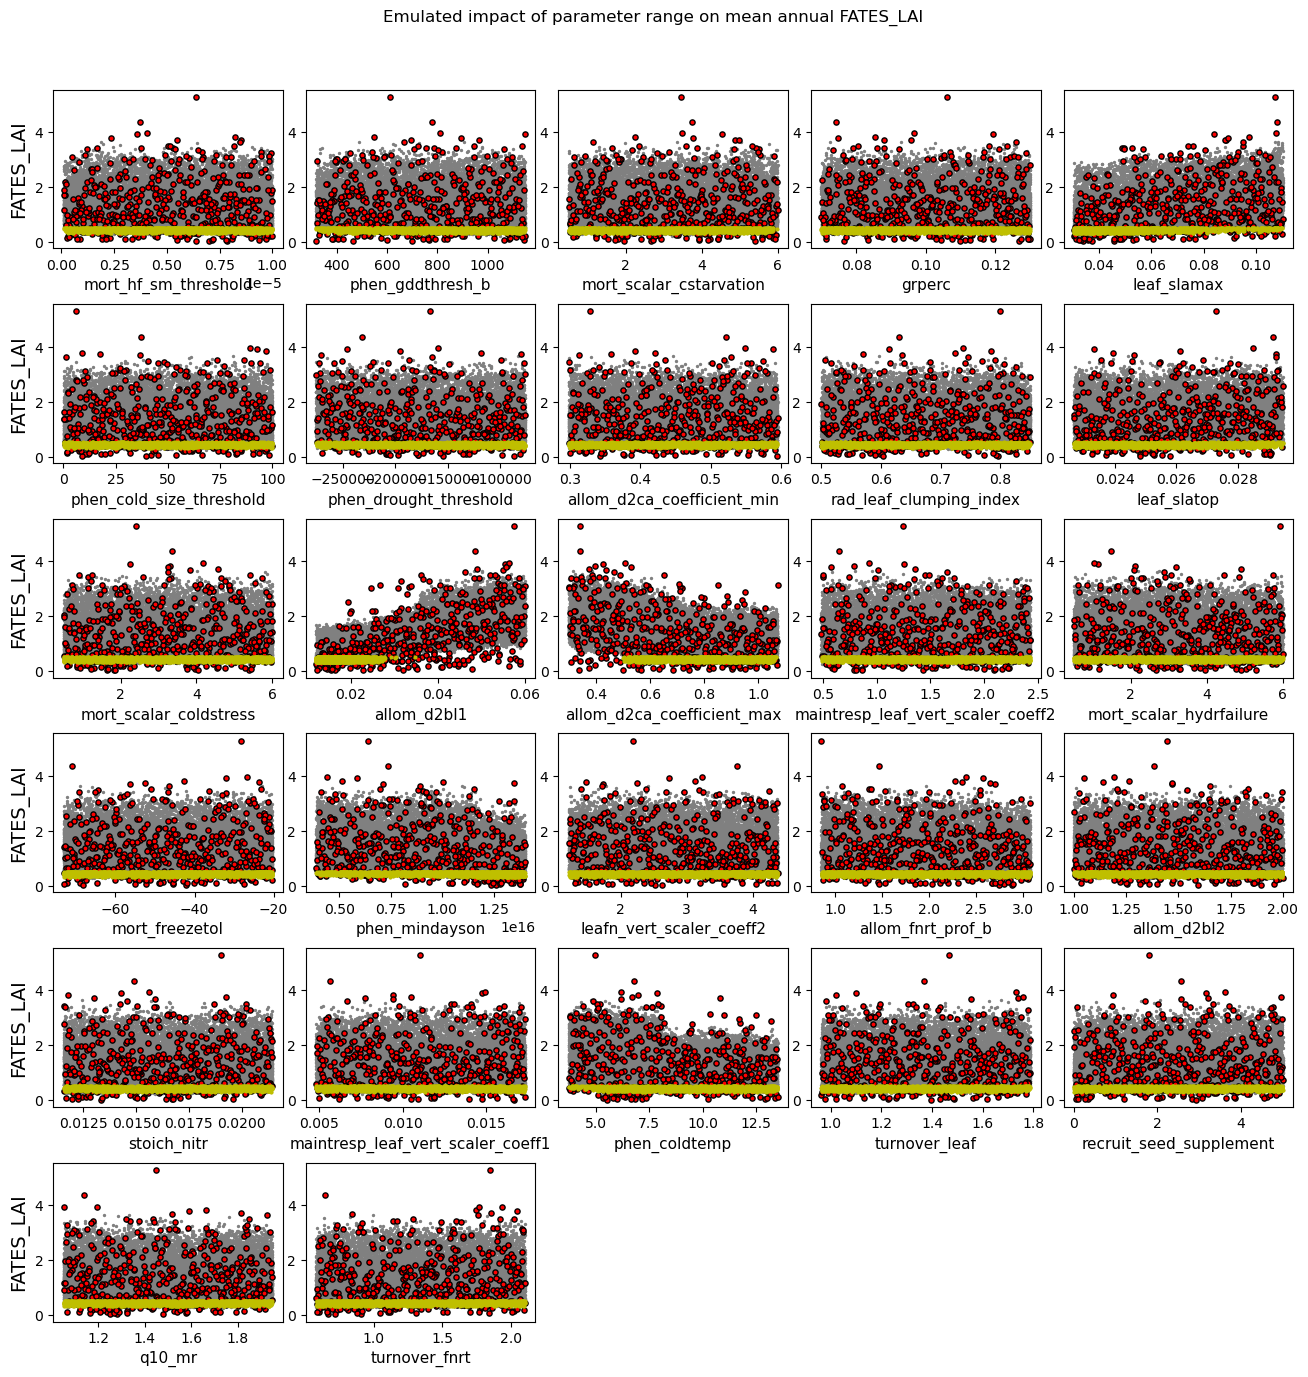

<Figure size 640x480 with 0 Axes>

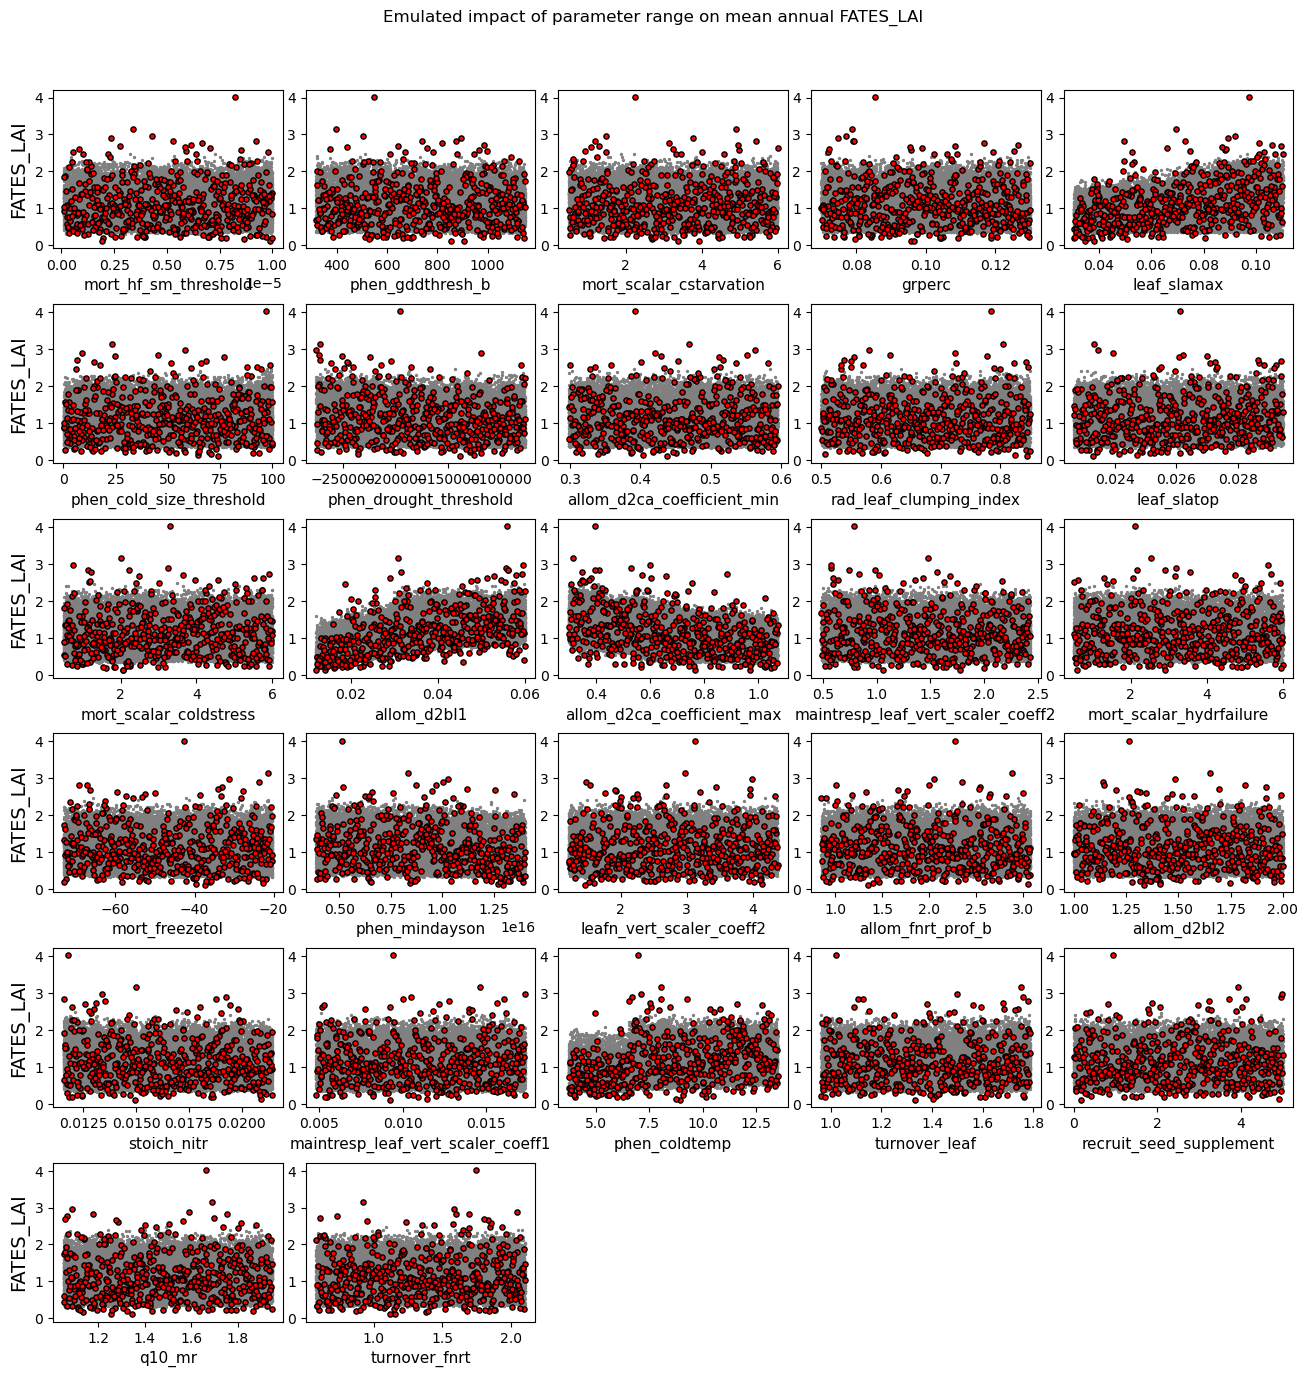

<Figure size 640x480 with 0 Axes>

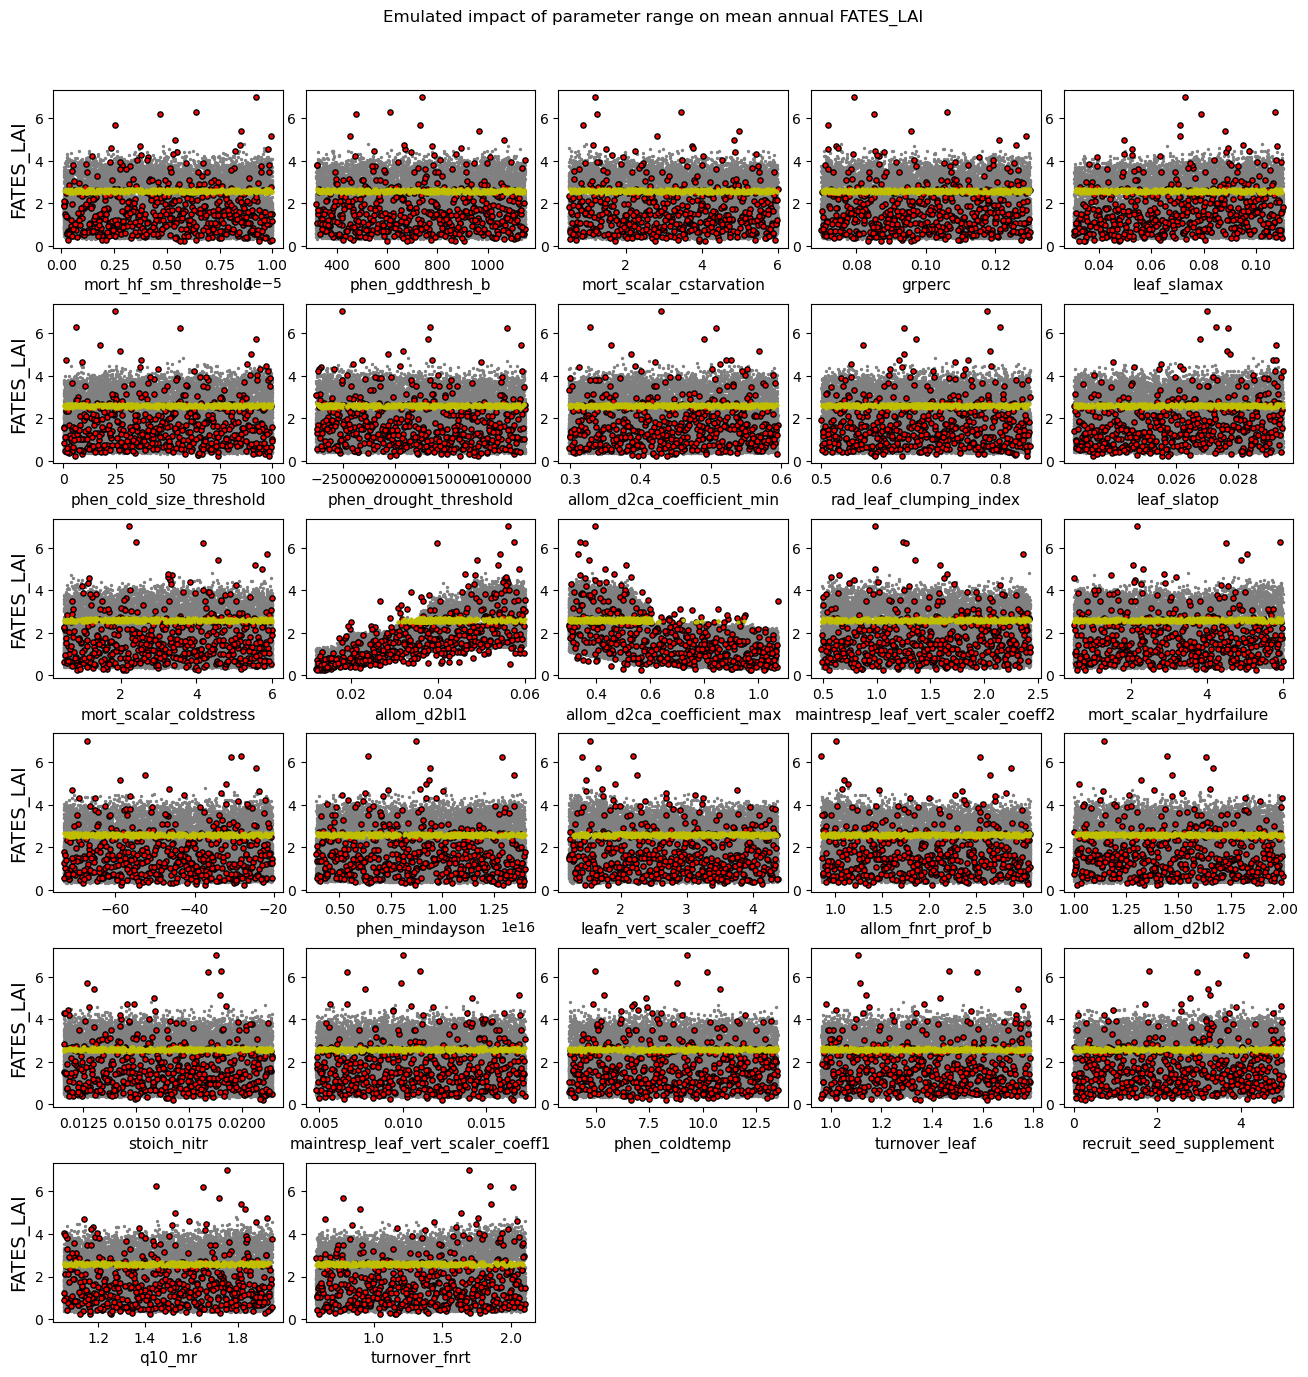

In [98]:
for g in range(0,nrep):
    draw_selected_param_space(g)

In [101]:
def plot_3d_param_space(g):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    plt.subplots_adjust(wspace=1.4, hspace=1.4)
    conv= 3600*24*365*1000
    accept_lai=accept_lai_g[g]
    print(feat_importance[g,:])
    xv=feat_importance[g,0]
    yv=feat_importance[g,1]
    zv=feat_importance[g,2]
    cv=feat_importance[g,3]
    print(xv,yv,zv,cv)
    xs = Xdense[accept_lai,xv]
    ys = Xdense[accept_lai,yv]
    zs = Xdense[accept_lai,zv]
    xsd = Xdense[:,xv]
    ysd = Xdense[:,yv]
    zsd = Xdense[:,zv]
    plt3d=ax.scatter(xsd, ysd, zsd, s=1,color='grey', alpha=0.05)
    plt3d=ax.scatter(xs,  ys,  zs,  s=8,c=Xdense[accept_lai,cv])
    
    ax.set_xlabel(lhc_vars_title[xv])
    ax.set_ylabel(lhc_vars_title[yv])
    ax.set_zlabel(lhc_vars_title[zv])
    print(g,np.shape(accept_lai))
    plt.colorbar(plt3d,fraction=0.04, pad=0.20,shrink=0.7,label=lhc_vars[cv])
    plt.savefig(figdir+'/3D_ensemble_plot_e'+str(ensN)+'_'+varn+'_g'+str(g)+'.png', bbox_inches='tight')
    plt.show()

FATES_LAI
[11 12 22 16]
11 12 22 16
0 (1, 2155)


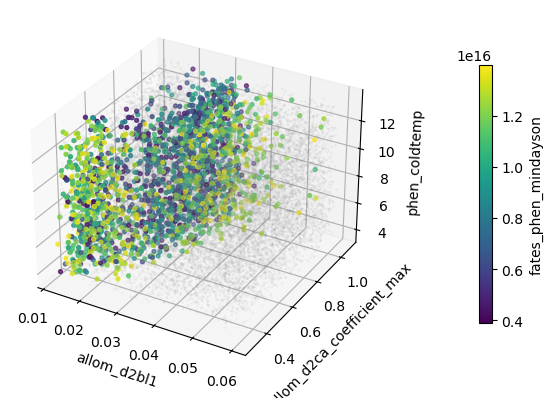

[11 12 16  4]
11 12 16 4
1 (1, 1672)


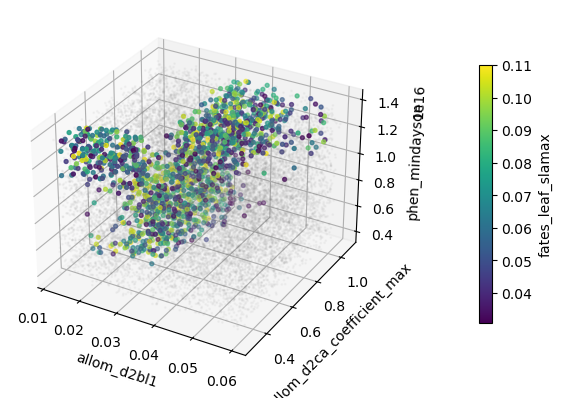

[11 12  4 16]
11 12 4 16
2 (1, 0)


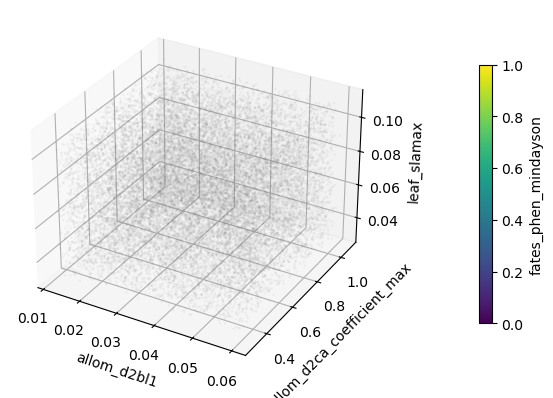

[11 12 22  4]
11 12 22 4
3 (1, 1497)


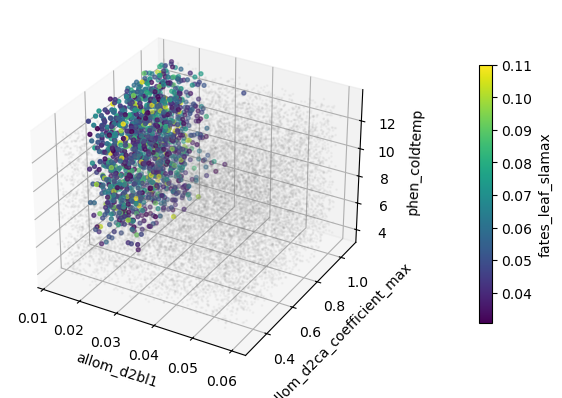

[11 12  4 22]
11 12 4 22
4 (1, 0)


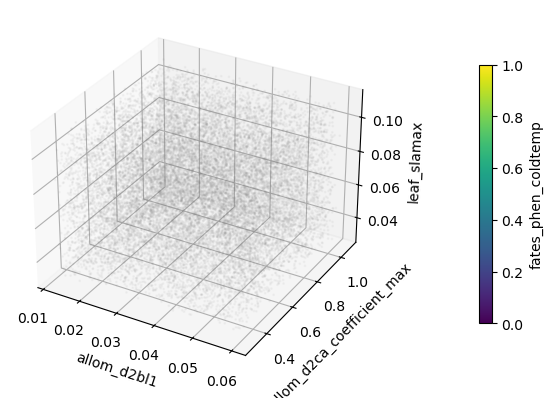

[11 12  4 17]
11 12 4 17
5 (1, 445)


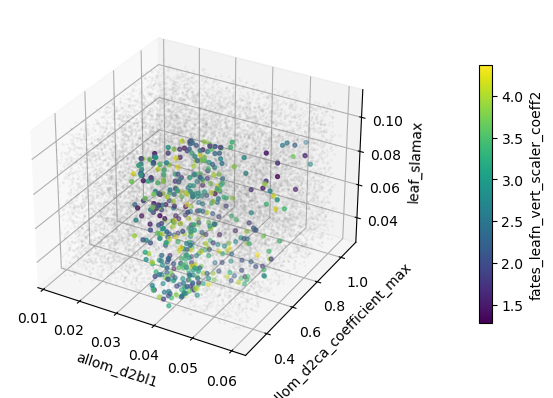

In [102]:
print(varn)
for g in range(0,nrep):
    plot_3d_param_space(g)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.subplots_adjust(wspace=1.4, hspace=1.4)
conv= 3600*24*365*1000
xv=4
yv=6

xs = Xdense[y_accept_cue,xv]
ys = Xdense[y_accept_cue,yv]
zs = y_cue_pred_noise[y_accept_cue]
plt3d=ax.scatter(xs, ys, zs, s=2,c='b')

xs = Xdense[y_accept_lai,xv]
ys = Xdense[y_accept_lai,yv]
zs = y_cue_pred_noise[y_accept_lai]
plt3d=ax.scatter(xs, ys, zs, s=5,c='r')


ax.set_zlim(0, 0.6)
ax.set_xlabel(paramlist[xv])
ax.set_ylabel(paramlist[yv])
ax.set_zlabel('LAI')
plt.colorbar(plt3d,fraction=0.04, pad=0.20,shrink=0.7,label=paramlist[cv])
plt.savefig('figs/3D_ensemble_filter_ensN'+str(ensN)+'_'+'cue'+'.png', bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
feat=np.zeros(400,4)
for g in range(0,355):
    feat[g,:]=random_forest(g,0,1)
    print(g,feat[g,:])
    


In [ ]:

for g in range(0,3):
    map_param_space(g)
    print('g='+str(g))

#### Run random forest to get top factors

In [ ]:
import pandas as pd
feat=np.zeros(400,4)
for g in range(0,355):
    feat[g,:]=random_forest(g,0,1)
    print(g,feat[g,:])
    


#### Resample the random forest to make larger ensemble. 

### Make map pf relative skill of emulator

In [ ]:
def get_map(da,sgmap=None):
    if not sgmap:
        sgmap=xr.open_dataset(sgpath)
    return da.sel(gridcell=sgmap.cclass).where(sgmap.notnan).compute()
    

In [ ]:
sgvar=l.FATES_LAI[0,:]
sgpath='../output_nocomp_ensemble_python/sgmap.nc'
sgvar[0:355]=lr_st[0:355]
sgvar[356:400]=0

mapped_var=np.flip(get_map(sgvar))
plt.imshow(np.flip(mapped_var,1),clim=[0,1] )                                    
colorbar = plt.colorbar( shrink=0.7)
filename=figdir+'/skillmap_lr_'+str(ensN)+'_'+fatesvar+'.png'
print(filename)
plt.text(10, 85, 'Linear Regression R$^{2}$')
plt.savefig(filename)  



In [ ]:
sgpath='../output_nocomp_ensemble_python/sgmap.nc'
sgvar[0:355]=rf_st[0:355]
sgvar[356:400]=0

mapped_var=np.flip(get_map(sgvar))
plt.imshow(np.flip(mapped_var,1),clim=[0,1                                     ])
colorbar = plt.colorbar( shrink=0.7)
filename=figdir+'/skillmap_rf_'+str(ensN)+'_'+fatesvar+'.png'
print(filename)
plt.text(10, 85, 'Random Forest R$^{2}$')
plt.savefig(filename)  



In [ ]:
sgpath='../output_nocomp_ensemble_python/sgmap.nc'
sgvar[0:355]=gp_st[0:355]
sgvar[356:400]=0

mapped_var=np.flip(get_map(sgvar))
plt.imshow(np.flip(mapped_var,1),clim=[0,1                                     ])
colorbar = plt.colorbar( shrink=0.7)
filename=figdir+'/skillmap_gp_'+str(ensN)+'_'+fatesvar+'.png'
print(filename)
plt.text(10, 85, 'Gaussian Process Emulator R$^{2}$')
plt.savefig(filename)  



#### Read in the observational datasets for each point from Adrianna's file

In [ ]:
ilamb_file='ILAMB_sparsegrid_data.csv'

ilamb_data = pd.read_csv(ilamb_file)



In [ ]:
rw=int(len(lhc_vars)/ncls)+1

fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(27, 16))
plt.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Impacts of parameter variation on ' + fatesvar,y=0.93, fontsize=26)
p=-1
axcount=0
timemean=dsc[fatesvar].mean('time')
g=140
yall=timemean.isel(gridcell=g)
yall=yall[0:len(x_array)]   
X=x_array

for i, var in enumerate(parlist):
    p=p+1
    print(p)

    row = axcount //ncls
    col = axcount % ncls        
    axcount=axcount+1
    
    #print(np.shape(paramv), fates_output_data.shape)
    axes[row, col].set_title(var,fontsize=20)    
    diffplot=axes[row, col].scatter(x_array[:,i],yall)
    if(row>1):
        axes[row, col].set_yticklabels([], fontsize=18) 
    if(col>1):
        axes[row, col].set_yticklabels([], fontsize=18) 
    axes[row, col].set_ylim([0,yl]) 
while axcount < rw*ncls:
    row = axcount //ncls
    col = axcount %ncls
    axes[row, col].remove()
    axcount += 1

plt.savefig(figpath+'x_vs_y'+fatesvar+'_y'+str(ychoose)+'.png',bbox_inches='tight')  
plt.show()

In [ ]:
av=xr.open_mfdataset(rt, decode_times=False)  
variables_containing_string =[var for var in av.variables if 'AREA' in var]

# Print the variables containing the specified string
print(variables_containing_string)